In [6]:
fpath ='/content/drive/MyDrive/ETLI/time_with_static_feat_v2_ape_nop_month_elapsed_avg_nop_gap_polcstat_reward_polbuck_cumrewards_qtr_target_avg_gap_correct_monthcomission_avgape.csv'

In [7]:
hierarc_data = '/content/drive/MyDrive/ETLI/agents_hierarchy.csv'

In [8]:
!pip install catboost

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import numpy as np
import pandas as pd
import warnings
import pprint

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dateutil.relativedelta import *
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,accuracy_score,f1_score,precision_score,recall_score
from catboost import CatBoostRegressor,CatBoostClassifier
from tqdm.notebook import tqdm
pd.set_option('display.max_rows', 25500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# from skopt.space import Real, Categorical, Integer
# from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
# from skopt.space import Real, Categorical, Integer
from time import time

In [11]:
def bucket_target(x):
    if x==0:
        return 0
    if 0<x<=25000:
        return 1
    if 25000<x<=50000:
        return 2
    if 50000<x<=75000:
        return 3
    if 75000<x<=100000:
        return 4
    if x>100000:
        return 5
final_df = pd.read_csv(fpath)
final_df['POL_GRS_APREM_AMT_bucket']=final_df['POL_GRS_APREM_AMT'].apply(bucket_target)

In [12]:
final_df['qtr_POL_GRS_APREM_AMT_bucket']=final_df['qtr_POL_GRS_APREM_AMT'].apply(bucket_target)

In [13]:
# hierarchical_df = pd.read_csv(hierarc_data)
# final_df[['SERV_AGT_ID','DM_CODE']].drop_duplicates(keep='first')
# final_df[['SERV_AGT_ID','DM_CODE']].drop_duplicates(keep='first')
# hierarchical_df.rename(columns={"AGENT CODE LVL1":"SERV_AGT_ID","AGENT CODE LVL2":"DM_CODE","AGENT CODE LVL3":"DM_CODE2"},inplace=True)
# temp_df= pd.merge(hierarchical_df,final_df,how='inner',on=['SERV_AGT_ID','DM_CODE'])
# temp_list  =  list(set(final_df['SERV_AGT_ID'].unique())-set(temp_df['SERV_AGT_ID'].unique()))
# len(temp_list)

In [14]:
# print (final_df.columns.tolist())
# [ 'Year', 'Month', 'Vintage', 'prem_lag_1', 'prem_lag_2', 'prem_lag_3', 
#  'nop_lag_1', 'nop_lag_2', 'nop_lag_3', 'months_since_license_issued', 'months_till_license_expire', 
#  'age',  'SERV_BR_ID', 'DESIGNATION_CODE', 'DM_CODE', 'LICENSE_TYPE', 'STATE_CODE',
#  'GENDER', 'EMAIL_ID', 'Total_policy_amount_sold', 'Total_Policy_sold', 'months_elapsed_last_sale',
#  'season_month', 'avg_nop_month', 'avg_gap_pol', 'num_policy(0, 1)', 'num_policy(1, 2)', 'num_policy(2, 5)', 'num_policy(5, 10)', 
#  'num_policy(10, 1000)', 'low', 'medium', 'high', 'training', 'recognition', 'trip', 'Total rejected pols', 'Rewards_won', 'quarter',
#  'qtr_POL_GRS_APREM_AMT', 'POL_GRS_APREM_AMT_bucket', 'qtr_POL_GRS_APREM_AMT_bucket', 'avg_gap_pol_corrected']


In [15]:
final_df.head(2)

,Unnamed: 0,SERV_AGT_ID,Year,Month,POL_GRS_APREM_AMT,Number of policies,Vintage,prem_lag_1,prem_lag_2,prem_lag_3,nop_lag_1,nop_lag_2,nop_lag_3,JOINING_DATE,LICENSE_ISSUE_DATE,LICENSE_EXPIRY_DATE,months_since_license_issued,months_till_license_expire,age,DOB,SERV_BR_ID,DESIGNATION_CODE,DM_CODE,LICENSE_TYPE,STATE_CODE,GENDER,EMAIL_ID,BATCH_ID,Total_policy_amount_sold,Total_Policy_sold,months_elapsed_last_sale,season_month,avg_nop_month,avg_gap_pol,"num_policy(0, 1)","num_policy(1, 2)","num_policy(2, 5)","num_policy(5, 10)","num_policy(10, 1000)",low,medium,high,training,recognition,trip,Total rejected pols,Rewards_won,quarter,qtr_POL_GRS_APREM_AMT,POL_GRS_APREM_AMT_bucket,qtr_POL_GRS_APREM_AMT_bucket,avg_gap_pol_corrected,MonthComission,avg_ape_month
0,0,A0A002,2019,12,0.0,0,3,14230.0,0.0,0.0,1,0,0,2019-09-03,2019-09-03,2022-09-03,3.0,33.0,24.0,1995-04-07,KD01A,A-PFA,A76263,Life,kl,Male,given,1000.0,14230.0,1,1,1,0.500000,10000.0,0,1,0,0,0,1,1,0,0,0,1,0,0,4,0.0,0,0,0.0,0.0,7115.000000
1,1,A0A002,2020,1,14682.0,1,4,0.0,14230.0,0.0,0,1,0,2019-09-03,2019-09-03,2022-09-03,4.0,32.0,25.0,1995-04-07,KD01A,A-PFA,A76263,Life,kl,Male,given,1000.0,14230.0,1,2,1,0.333333,10000.0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,4894.0,1,1,1.0,0.0,4743.333333


In [16]:
final_features = ['Year', 'Month', 'Vintage', 'prem_lag_1', 'prem_lag_2', 'prem_lag_3',
                  'nop_lag_1', 'nop_lag_2', 'nop_lag_3', 'months_since_license_issued',
                  'months_till_license_expire', 'age', 'SERV_BR_ID', 'DESIGNATION_CODE',
                  'DM_CODE', 'LICENSE_TYPE', 'STATE_CODE', 'GENDER', 'EMAIL_ID',
                  'Total_policy_amount_sold', 'Total_Policy_sold','months_elapsed_last_sale',
                  'season_month','avg_nop_month','avg_gap_pol_corrected','Total rejected pols','num_policy(0, 1)',
                  'num_policy(1, 2)', 'num_policy(2, 5)', 'num_policy(5, 10)', 'num_policy(10, 1000)', 
                  'low', 'medium', 'high', 'training', 'recognition', 'trip','quarter','Rewards_won','avg_ape_month','MonthComission']

In [17]:

categ_feat =  ['Month', 'SERV_BR_ID', 'DESIGNATION_CODE', 'DM_CODE','LICENSE_TYPE', 'STATE_CODE',
               'GENDER', 'EMAIL_ID','season_month','num_policy(0, 1)', 'num_policy(1, 2)', 'num_policy(2, 5)', 
               'num_policy(5, 10)', 'num_policy(10, 1000)', 'low', 'medium', 'high', 'training', 'recognition', 'trip','quarter']

In [18]:
# final_df = final_df[final_df['Vintage']>6]

In [19]:
final_df.dropna(inplace=True)

# test_index  = final_df[(final_df.Year==2020) & ((final_df.quarter==2) |(final_df.quarter==3))].index.tolist()
test_index= final_df[(final_df.Year==2020) & ((final_df.Month==5) |(final_df.Month==6) | ((final_df.Month==7)))].index.tolist()
train_index=  set(final_df.index.tolist())-set(test_index)
# final_features = reduced_cols
X_train, X_test, y_train, y_test =  final_df[final_features].loc[train_index],final_df[final_features].loc[test_index],final_df['POL_GRS_APREM_AMT_bucket'].loc[train_index],final_df['POL_GRS_APREM_AMT_bucket'].loc[test_index]
# categ_feat = ['DM_CODE','Month','SERV_BR_ID']
for col in categ_feat:
    X_train[col] =  X_train[col].astype(str)
    X_test[col] =  X_test[col].astype(str)

In [20]:
from catboost import Pool, cv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,StratifiedKFold


In [21]:
catboostclf  =  CatBoostClassifier(task_type = "GPU",verbose=None,auto_class_weights=None,od_type='Iter')


In [22]:
from sklearn.metrics import f1_score

from sklearn.metrics import make_scorer


In [ ]:
# tscv = TimeSeriesSplit(n_splits=5)
skf =StratifiedKFold(n_splits=5,random_state=2)

scoring = 'accuracy'

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(catboostclf, X_train, y_train, scoring=scoring, cv=skf, error_score='raise',fit_params={'cat_features':categ_feat})

In [26]:
# acc_aray = np.array([0.9360335 , 0.94939854, 0.94904213, 0.94950745, 0.9385971 ])
print ("accuracy  scores across 5 fold in stratify way")
print (n_scores)

accuracy  scores across 5 fold in stratify way
[0.93649882 0.94937874 0.94941835 0.94893322 0.94165635]


In [ ]:
##f1 score analysis
f1 = make_scorer(f1_score, average='macro')
n_scores = cross_val_score(catboostclf, X_train, y_train, scoring=f1, cv=skf, error_score='raise',fit_params={'cat_features':categ_feat})

In [28]:
print ("F1 scores across 5 fold in stratify way")
print (n_scores)

F1 scores across 5 fold in stratify way
[0.33448242 0.34674625 0.34492593 0.36184447 0.36517237]


In [29]:
catboostclf  =  CatBoostClassifier(task_type = "GPU",verbose=True,auto_class_weights=None,od_type='Iter')
# catboostclf  =  CatBoostClassifier(task_type = "GPU",verbose=True,class_weights=[2,0.96,0.986654,0.989709,0.994349,0.996115])

catboostclf.fit(X_train,y_train,cat_features =  categ_feat)

Learning rate set to 0.231079
0:	learn: 0.9616968	total: 43.3ms	remaining: 43.3s
1:	learn: 0.7375790	total: 82ms	remaining: 40.9s
2:	learn: 0.6083056	total: 117ms	remaining: 38.9s
3:	learn: 0.5251318	total: 151ms	remaining: 37.6s
4:	learn: 0.4240339	total: 189ms	remaining: 37.6s
5:	learn: 0.3640381	total: 223ms	remaining: 37s
6:	learn: 0.3213361	total: 262ms	remaining: 37.2s
7:	learn: 0.2905074	total: 292ms	remaining: 36.3s
8:	learn: 0.2671306	total: 320ms	remaining: 35.3s
9:	learn: 0.2487095	total: 348ms	remaining: 34.5s
10:	learn: 0.2353146	total: 377ms	remaining: 33.9s
11:	learn: 0.2247844	total: 404ms	remaining: 33.3s
12:	learn: 0.2168534	total: 443ms	remaining: 33.7s
13:	learn: 0.2106201	total: 475ms	remaining: 33.5s
14:	learn: 0.2059909	total: 501ms	remaining: 32.9s
15:	learn: 0.2024569	total: 527ms	remaining: 32.4s
16:	learn: 0.1997898	total: 550ms	remaining: 31.8s
17:	learn: 0.1974872	total: 576ms	remaining: 31.4s
18:	learn: 0.1956102	total: 601ms	remaining: 31s
19:	learn: 0.19

In [30]:
from sklearn.metrics import  classification_report
from sklearn.metrics import fbeta_score

prediction = catboostclf.predict(X_test)
print ("Accuracy is {}".format(accuracy_score(y_test,prediction)))
print(classification_report(prediction,y_test))

Accuracy is 0.9595164692519876
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     83795
           1       0.42      0.60      0.49      1854
           2       0.07      0.33      0.11       192
           3       0.02      0.36      0.04        28
           4       0.05      0.37      0.08        27
           5       0.28      0.30      0.29       386

    accuracy                           0.96     86282
   macro avg       0.31      0.49      0.33     86282
weighted avg       0.98      0.96      0.97     86282



In [31]:
res_dataframe = pd.DataFrame(columns=['class_0','class_1','class_2','class_3','class_4','class_5'],data=catboostclf.predict_proba(X_test))
res_dataframe

,class_0,class_1,class_2,class_3,class_4,class_5
0,0.948479,0.034565,0.011829,0.002205,0.002580,0.000340
1,0.967143,0.027957,0.004028,0.000414,0.000241,0.000217
2,0.944341,0.047933,0.006219,0.000460,0.000398,0.000649
3,0.605035,0.148561,0.059531,0.045524,0.009140,0.132210
4,0.591526,0.142534,0.085518,0.068440,0.011234,0.100748
...,...,...,...,...,...,...
86277,0.964836,0.021347,0.006102,0.002502,0.001049,0.004164
86278,0.977043,0.014049,0.004133,0.001362,0.000676,0.002737
86279,0.989256,0.007471,0.002264,0.000538,0.000195,0.000276
86280,0.990465,0.007001,0.001642,0.000422,0.000185,0.000285


In [32]:
res_dataframe['groundtruth']= y_test.values
res_dataframe['SERV_AGT_ID']= final_df.loc[test_index]['SERV_AGT_ID'].values
res_dataframe

,class_0,class_1,class_2,class_3,class_4,class_5,groundtruth,SERV_AGT_ID
0,0.948479,0.034565,0.011829,0.002205,0.002580,0.000340,1,A0A002
1,0.967143,0.027957,0.004028,0.000414,0.000241,0.000217,1,A0A002
2,0.944341,0.047933,0.006219,0.000460,0.000398,0.000649,2,A0A002
3,0.605035,0.148561,0.059531,0.045524,0.009140,0.132210,1,A0A003
4,0.591526,0.142534,0.085518,0.068440,0.011234,0.100748,1,A0A003
...,...,...,...,...,...,...,...,...
86277,0.964836,0.021347,0.006102,0.002502,0.001049,0.004164,0,A48131
86278,0.977043,0.014049,0.004133,0.001362,0.000676,0.002737,0,A48131
86279,0.989256,0.007471,0.002264,0.000538,0.000195,0.000276,0,A48132
86280,0.990465,0.007001,0.001642,0.000422,0.000185,0.000285,0,A48132


In [ ]:
# res_dataframe['month']= final_df.loc[test_index]['Month'].values


In [ ]:
# res_dataframe.to_csv('kps_test_sheet.csv',index=None)

In [33]:
y_actu = pd.Series(y_test.values.tolist(), name='Actual')
y_pred = pd.Series(prediction.flatten(), name='Predicted')
df_confusion_cat= pd.crosstab(y_actu, y_pred)
df_confusion_cat

Predicted,0,1,2,3,4,5
Actual,,,,,,
0,81478,111,9,2,0,24
1,1365,1112,68,7,2,89
2,469,350,64,1,7,76
3,199,141,17,10,1,49
4,96,59,14,3,10,33
5,188,81,20,5,7,115


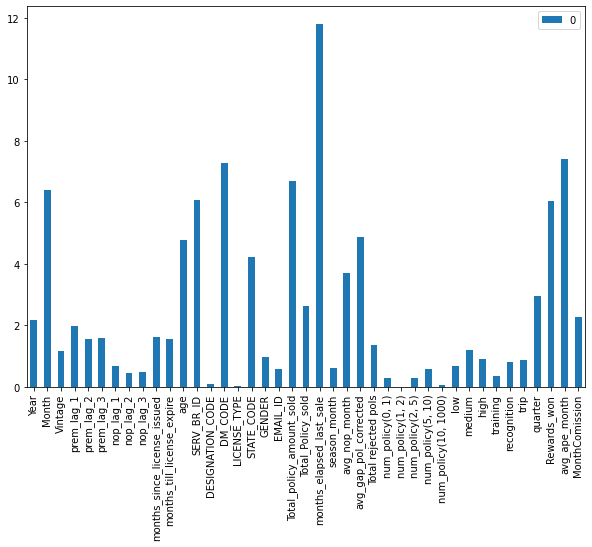

In [34]:
feat_import_df = pd.DataFrame(columns=X_train.columns.tolist(),data=[catboostclf.feature_importances_]).T
fig = plt.figure(figsize = (10,7))
ax = fig.gca()
feat_import_df.plot(kind='bar',ax=ax)

In [40]:
model_path ='/content/drive/MyDrive/ETLI/catboost_v1'
catboostclf.save_model(model_path)

In [37]:
fpath

'/content/drive/MyDrive/ETLI/time_with_static_feat_v2_ape_nop_month_elapsed_avg_nop_gap_polcstat_reward_polbuck_cumrewards_qtr_target_avg_gap_correct_monthcomission_avgape.csv'